In [3]:
# !pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp311-cp311-linux_x86_64.whl size=102347 sha256=748ec7a15d30fe443cec62cdfc7ce8577061703a0d1c7d151aa1b94f1b9bd88f
  Stored in directory: /tmp/pip-ephem-wheel-cache-r2krs47g/wheels/ad/ca/ea/fb115e04c841c3f71fd369b7d9805a43a5193f4f9251bed0ec
Successfully built pycocotools


code skeleton adopted from : https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5

In [5]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # load meta data(altitude)
        altitude = []
        for key in ['altitude', 'height_above_takeoff(meter)', 'null']:
            if coco.loadImgs(img_id)[0]['meta'] and key in coco.loadImgs(img_id)[0]['meta']:
                altitude.append( coco.loadImgs(img_id)[0]['meta'][key] )
                break
        # if altitude is not None:
        #     altitude = torch.tensor(altitude, dtype=torch.float32)
        # else:
        #     # altitude = torch.as_tensor(0, dtype=torch.float32)
        #     pass
        altitude = torch.as_tensor(altitude, dtype=torch.float32)
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["altitude"] = altitude
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [6]:
# path to your own data and coco file
train_data_dir = '/mnt/i/DL Datasets/2023/Potential/SeaDronesSee/SeaDronesSee Object Detection v2/Compressed Version/images/val/'
train_coco = '/mnt/i/DL Datasets/2023/Potential/SeaDronesSee/SeaDronesSee Object Detection v2/Compressed Version/annotations/instances_val.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 2

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=False,
                                          num_workers=6,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [7]:
def Dataloader_by_Index(data_loader, target=0):
    for index, data in enumerate(data_loader):
        if index == target:
            return data
    return None

In [8]:
img, ann = Dataloader_by_Index(data_loader, target=0)
img

(tensor([[[0.3020, 0.3490, 0.2980,  ..., 0.1843, 0.1804, 0.1843],
          [0.3608, 0.3333, 0.2275,  ..., 0.1882, 0.1882, 0.1882],
          [0.4078, 0.3333, 0.2039,  ..., 0.1961, 0.1922, 0.1961],
          ...,
          [0.4471, 0.4510, 0.4510,  ..., 0.1529, 0.1647, 0.1490],
          [0.3882, 0.3961, 0.4000,  ..., 0.1412, 0.1490, 0.1373],
          [0.3725, 0.3804, 0.3843,  ..., 0.1529, 0.1647, 0.1529]],
 
         [[0.4157, 0.4510, 0.3765,  ..., 0.2039, 0.2078, 0.2118],
          [0.4314, 0.3922, 0.2824,  ..., 0.2078, 0.2157, 0.2157],
          [0.3961, 0.3294, 0.2078,  ..., 0.2157, 0.2196, 0.2235],
          ...,
          [0.4471, 0.4510, 0.4471,  ..., 0.2039, 0.2235, 0.2078],
          [0.3882, 0.3961, 0.3922,  ..., 0.1922, 0.2078, 0.1961],
          [0.3725, 0.3804, 0.3765,  ..., 0.2039, 0.2196, 0.2196]],
 
         [[0.4078, 0.4471, 0.3804,  ..., 0.2824, 0.2824, 0.2863],
          [0.4392, 0.4039, 0.2941,  ..., 0.2863, 0.2902, 0.2902],
          [0.4235, 0.3529, 0.2275,  ...,

In [9]:
img, annotations = next(iter(data_loader))
print(annotations)
img[0].shape

({'boxes': tensor([[ 985.,   64., 1018.,   93.]]), 'altitude': tensor([226.8190]), 'labels': tensor([1]), 'image_id': tensor([48]), 'area': tensor([957.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[642., 426., 667., 459.],
        [484.,  15., 505.,  46.],
        [430., 179., 447., 213.],
        [271., 155., 301., 182.],
        [393., 193., 408., 205.],
        [352., 200., 364., 211.]]), 'altitude': tensor([229.7220]), 'labels': tensor([1, 1, 1, 1, 1, 1]), 'image_id': tensor([71]), 'area': tensor([825., 651., 578., 810., 180., 132.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0])})


torch.Size([3, 933, 1230])

In [10]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    # imgs = list(img.to(device) for img in imgs)
    # annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

cuda
({'boxes': tensor([[ 985.,   64., 1018.,   93.]]), 'altitude': tensor([226.8190]), 'labels': tensor([1]), 'image_id': tensor([48]), 'area': tensor([957.]), 'iscrowd': tensor([0])}, {'boxes': tensor([[642., 426., 667., 459.],
        [484.,  15., 505.,  46.],
        [430., 179., 447., 213.],
        [271., 155., 301., 182.],
        [393., 193., 408., 205.],
        [352., 200., 364., 211.]]), 'altitude': tensor([229.7220]), 'labels': tensor([1, 1, 1, 1, 1, 1]), 'image_id': tensor([71]), 'area': tensor([825., 651., 578., 810., 180., 132.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0])})
({'boxes': tensor([[552.,  60., 569.,  94.],
        [725., 488., 743., 519.],
        [919., 363., 951., 385.],
        [771., 326., 792., 360.],
        [862., 323., 877., 336.],
        [834., 329., 848., 343.]]), 'altitude': tensor([228.2770]), 'labels': tensor([1, 1, 1, 1, 1, 1]), 'image_id': tensor([85]), 'area': tensor([578., 558., 704., 714., 195., 196.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0])}, {

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([3, 1012, 1920]) torch.ByteTensor


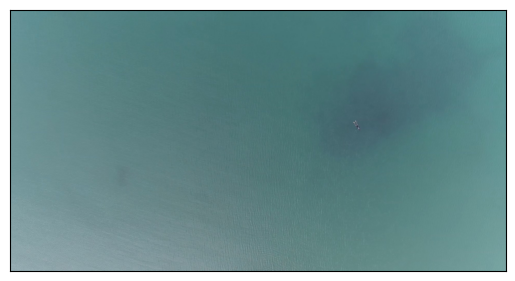

In [12]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

image11 = read_image("DJI_0915_0009_60m_3.mp4_20230506_090622.659.jpg")
print(image11.shape, image11.type())
grid = make_grid(image11)
show(grid)

In [16]:
img, ann = Dataloader_by_Index(data_loader, target=1)
print(img[0].shape)
img = torchvision.transforms.ToPILImage()(img[0])
# img.shape

torch.Size([3, 933, 1230])


In [17]:
from torchvision.utils import draw_bounding_boxes


# img, ann = Dataloader_by_Index(data_loader, target=1)
# boxes = ann[0]["boxes"]
# img = (img[0])
# # colors = ["blue", "yellow"]
# result = draw_bounding_boxes(F.to_pil_image(img), boxes, width=5)
# show(result)
# boxes

In [18]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")
session = fo.launch_app(dataset)

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
